In [1]:
import os
import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from PIL import Image

### Dataset exploration

In [2]:
len(os.listdir('continuum_data_subset'))

150

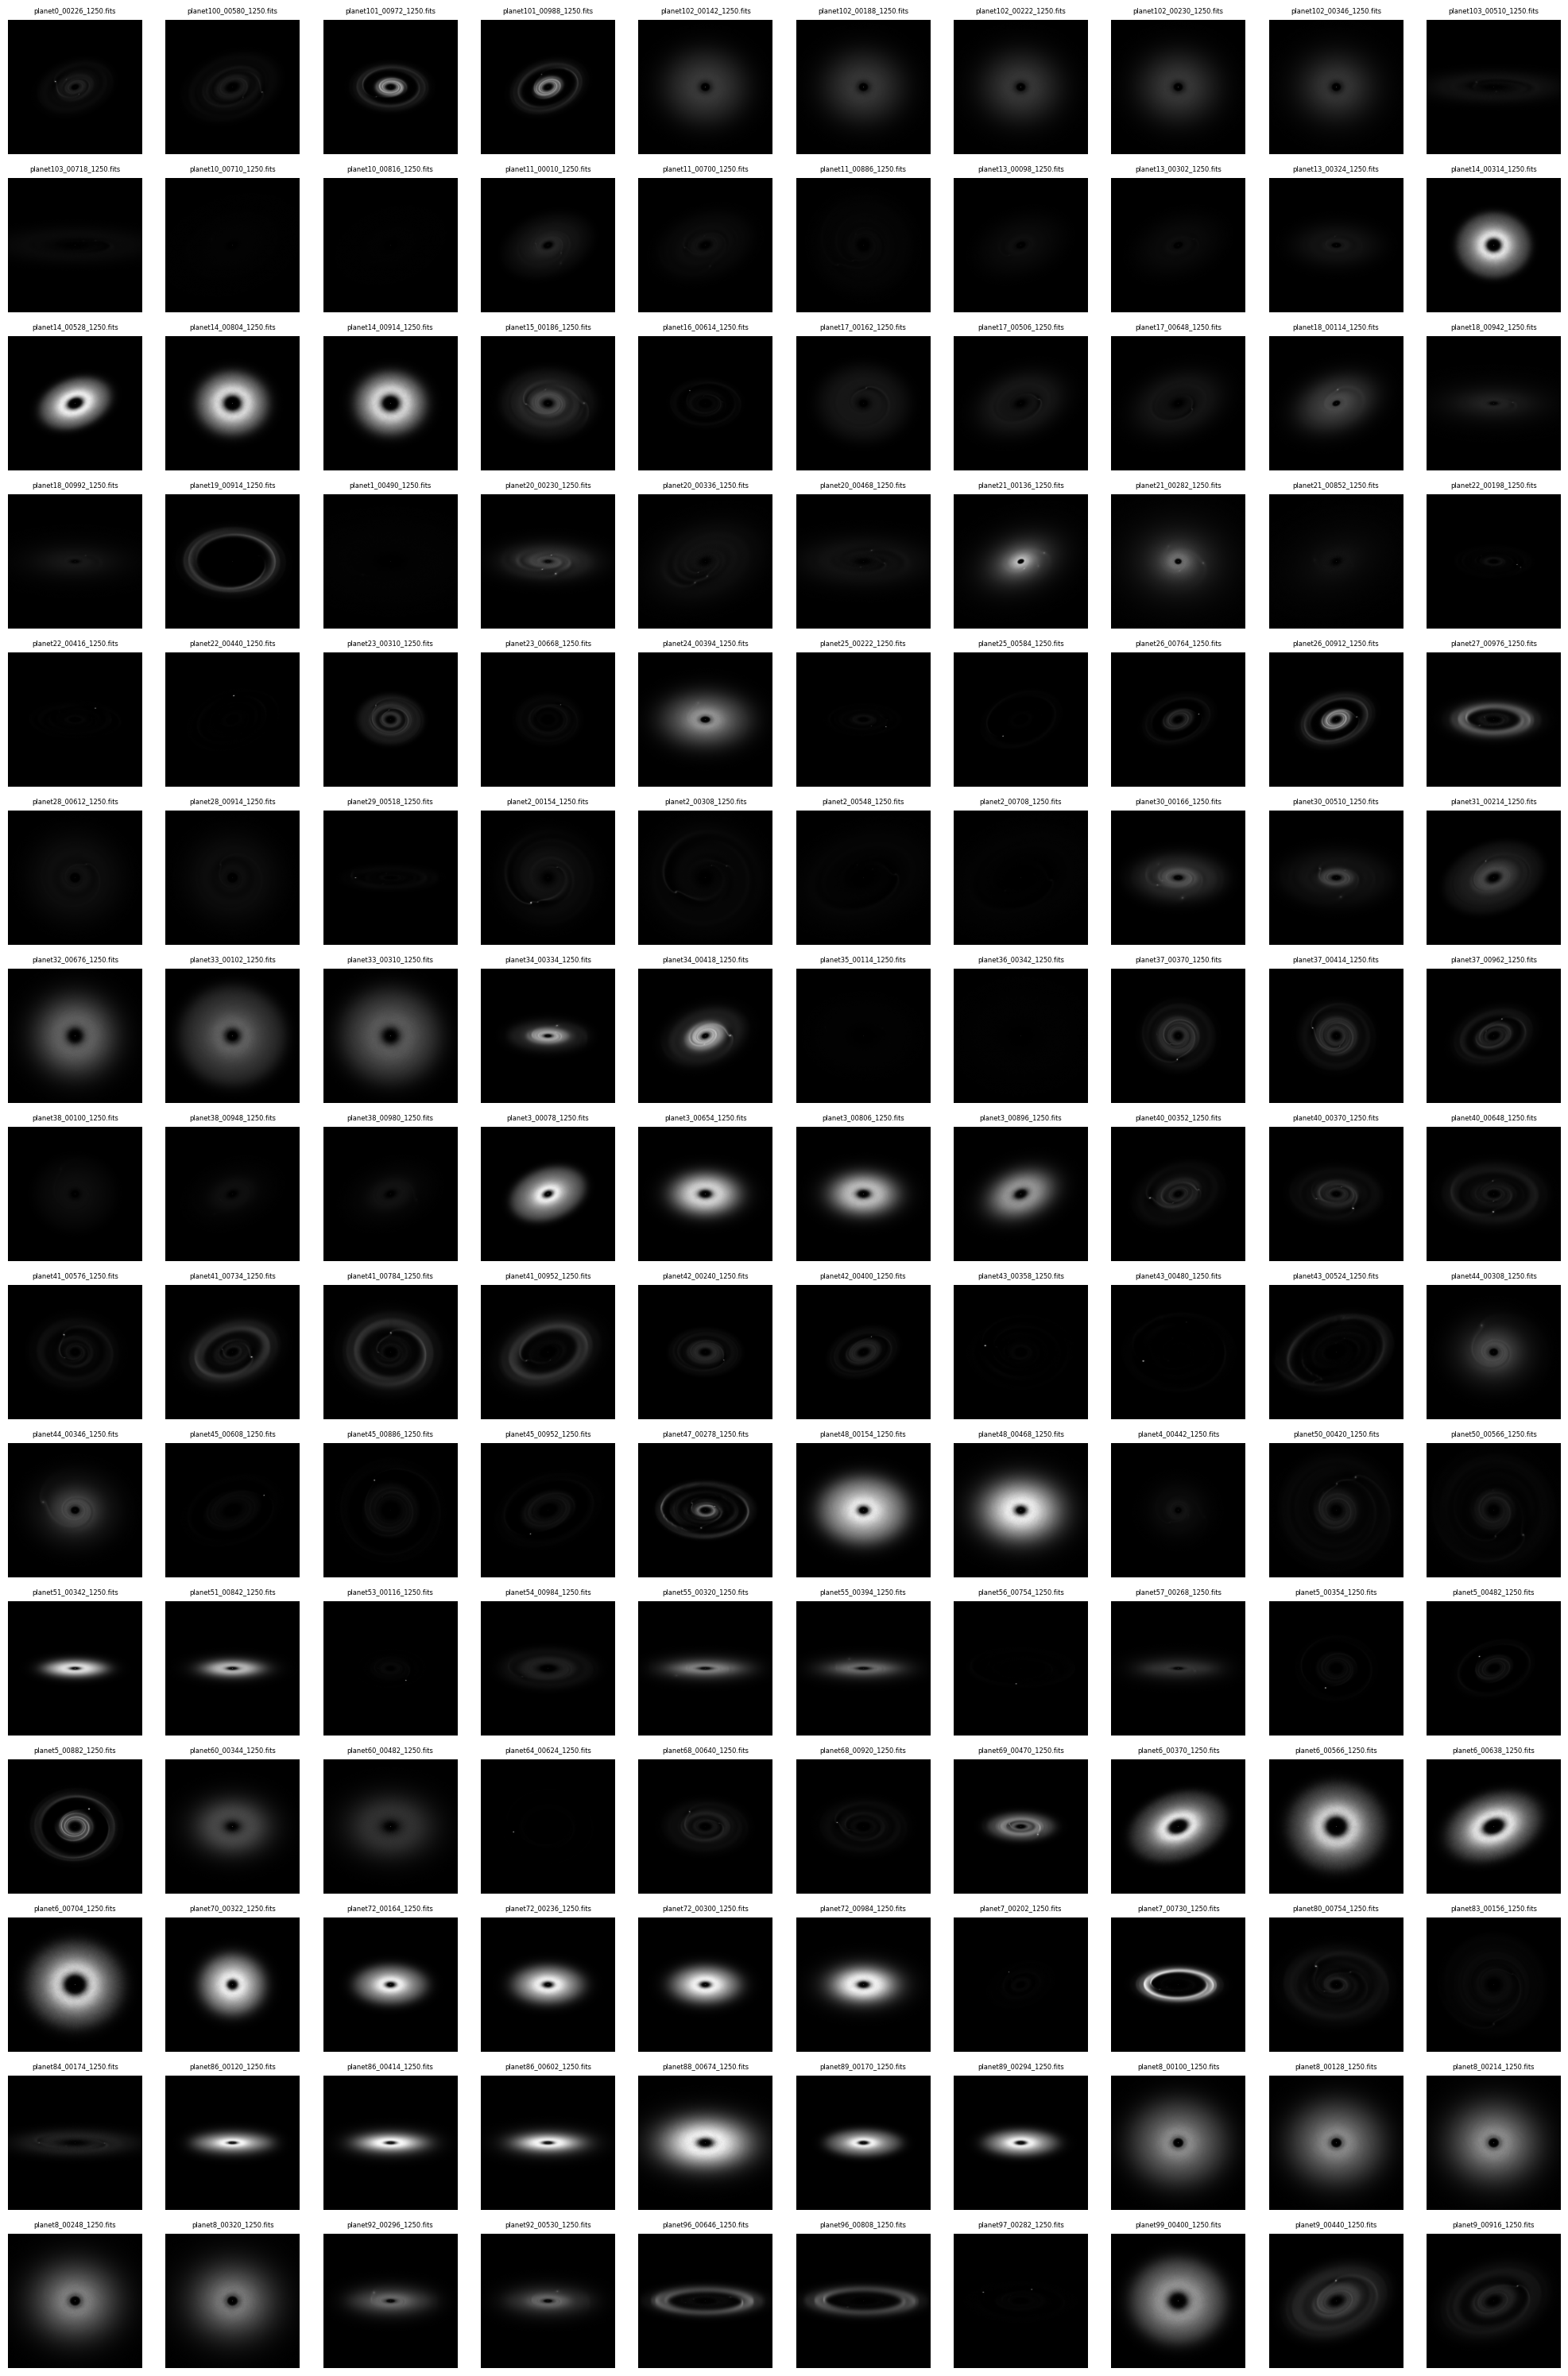

In [3]:
fits_dir = "continuum_data_subset" 

# Retrieve list of all FITS files in the directory
fits_files = glob.glob(f"{fits_dir}/*.fits")
fits_files.sort()

num_images = len(fits_files)  # should equal 150
cols = 10  # number of columns for grid layout
rows = math.ceil(num_images / cols)  # compute number of rows needed

# Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
axes = axes.flatten()

for ax, file in zip(axes, fits_files):
    # Open the FITS file and retrieve the first image layer (index 0)
    with fits.open(file) as hdul:
        image_data = hdul[0].data[0, 0, 0, ...]
    # Plot the image
    ax.imshow(image_data, origin='lower', cmap='gray')
    ax.set_title(file.split('/')[-1], fontsize=6)
    ax.axis('off')

# Hide any unused subplot axes
for ax in axes[len(fits_files):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

planet0_00226_1250.fits -> min: 0.0, max: 2.3296134776162404e-20, mean: 2.2350168725435096e-22
planet100_00580_1250.fits -> min: 0.0, max: 5.356415326729233e-21, mean: 6.835984614719409e-23
planet101_00972_1250.fits -> min: 0.0, max: 8.672344103352072e-21, mean: 1.7174747675802952e-22
planet101_00988_1250.fits -> min: 0.0, max: 3.363145118404418e-21, mean: 6.608531403283948e-23
planet102_00142_1250.fits -> min: 0.0, max: 1.6793940409263506e-21, mean: 8.73678472443906e-23


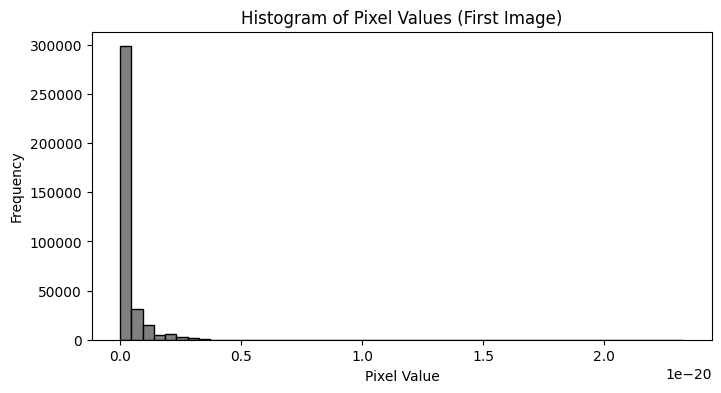

In [4]:
# Check statistics for the first 5 images
for file in fits_files[:5]:
    with fits.open(file) as hdul:
        # Extract the first layer (adjust indices if necessary)
        image_data = hdul[0].data[0, 0, 0, ...]
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    mean_val = np.mean(image_data)
    print(f"{file.split('/')[-1]} -> min: {min_val}, max: {max_val}, mean: {mean_val}")

# Plot histogram for the first image
with fits.open(fits_files[0]) as hdul:
    image_data = hdul[0].data[0, 0, 0, ...]
plt.figure(figsize=(8, 4))
plt.hist(image_data.flatten(), bins=50, color='gray', edgecolor='black')
plt.title("Histogram of Pixel Values (First Image)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

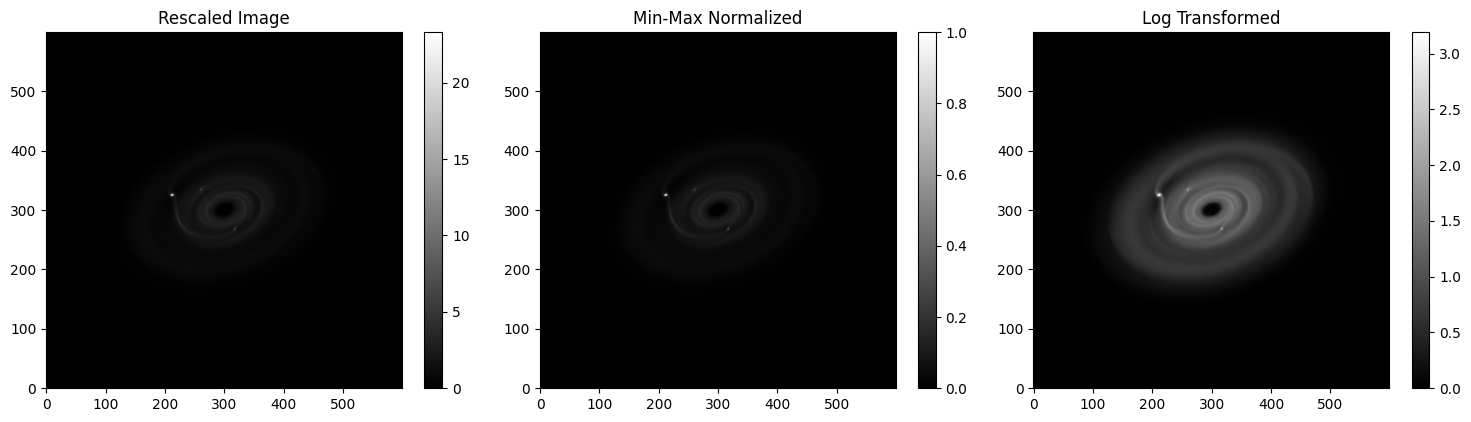

In [5]:
# Function for simple rescaling
def rescale_image(image, scale_factor=1e21):
    return image * scale_factor

# Function for min-max normalization
def min_max_normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val - min_val > 0:
        return (image - min_val) / (max_val - min_val)
    else:
        return image

# Function for log transformation after rescaling
def log_rescale(image, scale_factor=1e21):
    image_scaled = rescale_image(image, scale_factor)
    return np.log1p(image_scaled)

# Let's take the first image and apply these approaches
with fits.open(fits_files[0]) as hdul:
    image_data = hdul[0].data[0, 0, 0, ...]

# Rescaled image
img_rescaled = rescale_image(image_data)
# Min-max normalized image
img_minmax = min_max_normalize(image_data)
# Log transformed image
img_log = log_rescale(image_data)

# Plot comparisons
plt.figure(figsize=(15, 4))

plt.subplot(1,3,1)
plt.imshow(img_rescaled, origin='lower', cmap='gray')
plt.title("Rescaled Image")
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(img_minmax, origin='lower', cmap='gray')
plt.title("Min-Max Normalized")
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(img_log, origin='lower', cmap='gray')
plt.title("Log Transformed")
plt.colorbar()

plt.tight_layout()
plt.show()

### Trying to understand the problem.

**Exoplanets.** An exoplanet is a planet orbiting a star other than our Sun [1]. Exoplanets are extremely faint light sources compared to their host stars, and what little light they do emit tends to be lost in the star's glare . Planets orbiting far enough away from their stars to be resolvable reflect very little starlight, so they are detected through their thermal emission instead [2]. 

Young L/T-type exoplanets can have temperatures below 1000 K [3]. On the other hand, the coldest and oldest known directly imaged exoplanet, Epsilon Indi Ab, has an effective temperature of 275 K [4].

**Blackbody.** Looking at the theoretical radiance emitted by a black body in the wavelength range measured by ALMA, it seems incredible to me how something can be characterized with so little information. We are almost literally looking at “nothing”.

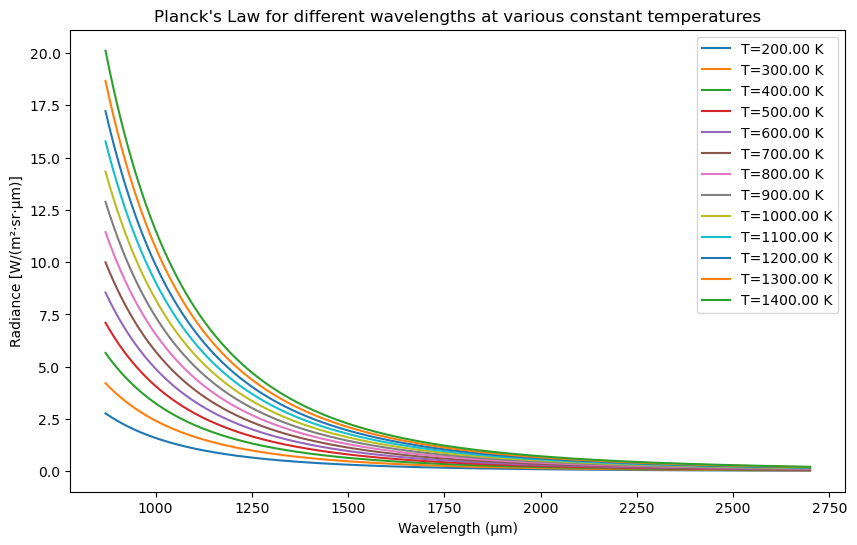

[1] https://elt.eso.org/science/exoplanets/

[2] https://en.wikipedia.org/wiki/Methods_of_detecting_exoplanets

[3] https://comptes-rendus.academie-sciences.fr/physique/item/10.5802/crphys.139.pdf

[4] https://en.wikipedia.org/wiki/List_of_directly_imaged_exoplanets

### PyTorch Dataset 

In [6]:
class ALMADataset:
    def __init__(self, fits_dir, transform=None):
        self.files = sorted(glob.glob(os.path.join(fits_dir, '*.fits')))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        file = self.files[index]
        with fits.open(file) as hdul:
            image = hdul[0].data[0, 0, 0, ...]
        image = np.array(image, dtype=np.float32).copy()
        label = -1  # dummy label
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [7]:
class LogTransform(object):
    def __init__(self, scale_factor=1e21, eps=1e-10):
        self.scale_factor = scale_factor
        self.eps = eps

    def __call__(self, image):
        # image is a numpy array
        arr = np.array(image, dtype=np.float32)
        arr = np.log1p(arr * self.scale_factor + self.eps)
        arr = np.uint8(arr * 255 / arr.max())
        return arr

In [8]:
fits_dir = "continuum_data_subset"
dataset = ALMADataset(fits_dir, transform=LogTransform())

# Extract and flatten images.
flattened_data = []
for i in range(len(dataset)):
    image, _ = dataset[i]
    # Ensure image is a NumPy array.
    if isinstance(image, Image.Image):
        image = np.array(image)
    flattened_data.append(image.flatten())
    
# Stack data into a 2D array: (num_samples, num_features)
data_array = np.vstack(flattened_data)
print("Data array shape:", data_array.shape)

Data array shape: (150, 360000)


### Principal component analysis (PCA)

The elbow method objectively selects the optimal number of principal components by identifying the point where additional components yield diminishing returns in explained variance. This ensures that the extracted features efficiently capture the data’s variance, balancing dimensionality reduction with information preservation, and thus optimizing subsequent analyses and clustering tasks.



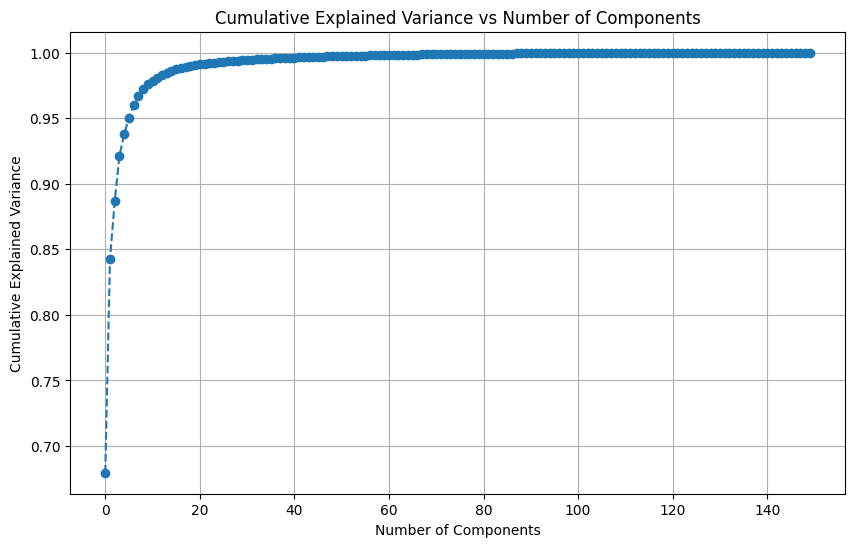

Components to retain 90% variance: 4
Components to retain 95% variance: 6
Components to retain 99% variance: 20


In [9]:
pca_full = PCA()
pca_full.fit(data_array)
explained_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

# Print the required number of components at thresholds.
thresholds = [0.90, 0.95, 0.99]
for threshold in thresholds:
    num_components = np.argmax(explained_variance_ratio >= threshold) + 1
    print(f'Components to retain {int(threshold*100)}% variance: {num_components}')

In [10]:
selected_components = 20  
pca_reducer = PCA(n_components=selected_components)
reduced_data = pca_reducer.fit_transform(data_array)
print("Reduced data shape:", reduced_data.shape)

Reduced data shape: (150, 20)


### Unsupervised Clustering

In [ ]:
def plot_cluster_samples(dataset, clusters, num_samples=9):
    """
    Visualizes sample images from each cluster in a grid.
    
    Parameters:
      dataset: Instance of ALMADataset (or similar) that returns an image as a numpy array or PIL image.
      clusters: A numpy array of cluster labels corresponding to each sample in the dataset.
      num_samples: Number of samples to display per cluster.
    """
    unique_clusters = np.unique(clusters)
    
    for uc in unique_clusters:
        # Get the indices of samples belonging to the current cluster
        indices = np.where(clusters == uc)[0]
        print(f"Cluster {uc} has {len(indices)} samples.")
        
        # Choose at most num_samples from the cluster
        sample_indices = indices[:num_samples]
        n = len(sample_indices)
        
        # Calculate grid dimensions
        grid_cols = int(math.ceil(math.sqrt(n)))
        grid_rows = int(math.ceil(n / grid_cols))
        
        fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols*2, grid_rows*2))
        # Flatten axs to easily iterate
        if grid_rows == 1 and grid_cols == 1:
            axs = [axs]
        elif grid_rows == 1 or grid_cols == 1:
            axs = np.array(axs).flatten()
        else:
            axs = axs.flatten()
        
        for i, idx in enumerate(sample_indices):
            image, _ = dataset[idx]
            # Convert to PIL image if necessary (for consistent display)
            if not isinstance(image, Image.Image):
                image = Image.fromarray(image)
            axs[i].imshow(image, cmap='gray')
            axs[i].set_title(f"Idx: {idx}", fontsize=8)
            axs[i].axis("off")
            
        # Hide any unused axes
        for j in range(i + 1, len(axs)):
            axs[j].axis("off")
            
        fig.suptitle(f"Cluster {uc} Samples", fontsize=12)
        plt.tight_layout()
        plt.show()

#### Presence vs No Planet

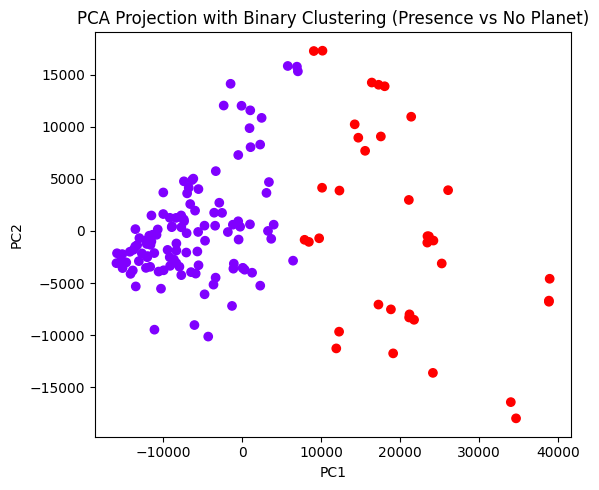

Cluster 0 has 114 samples.


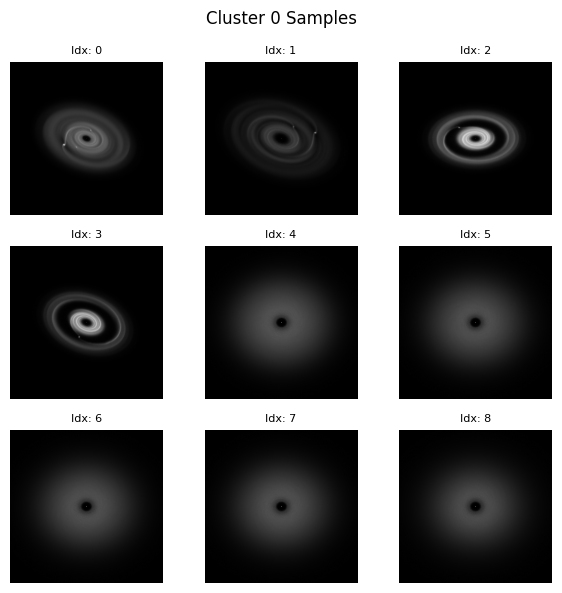

Cluster 1 has 36 samples.


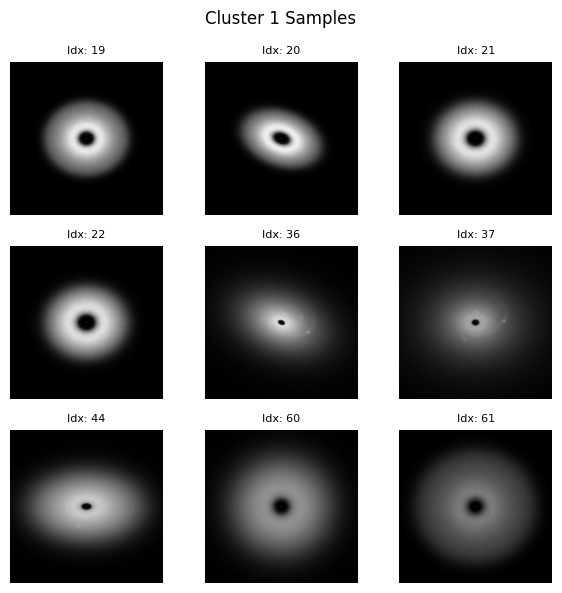

In [12]:
binary_kmeans = KMeans(n_clusters=2, n_init='auto')
binary_clusters = binary_kmeans.fit_predict(reduced_data)

# Plot the PCA projection with the binary clusters
plt.figure(figsize=(6, 5))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=binary_clusters, cmap='rainbow')
plt.title('PCA Projection with Binary Clustering (Presence vs No Planet)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# Visualize sample images for each cluster (using your defined plot_cluster_samples)
plot_cluster_samples(dataset, binary_clusters, num_samples=9)

In our initial experiment using k=2, the binary clustering distinguished two groups. One cluster appeared more concentrated, while the other was more diffuse. The orange-colored samples exhibited less correlation compared to the purple-colored ones. Observations indicate that images in Cluster 1 tend to have higher white intensity, suggesting disks without prominent planets. However, some images with potential planetary signs still fall in this group due to overall white intensity.

Overall, the method primarily segregates images based on the intensity of white regions in the disks, which may not effectively capture subtle planetary features. It seems that the algorithm struggles to accurately predict the presence of exoplanets, instead grouping them by disk brightness and sparsity

#### Number of planets

/tmp/ipykernel_45668/3735712473.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='gray', cmap='rainbow')


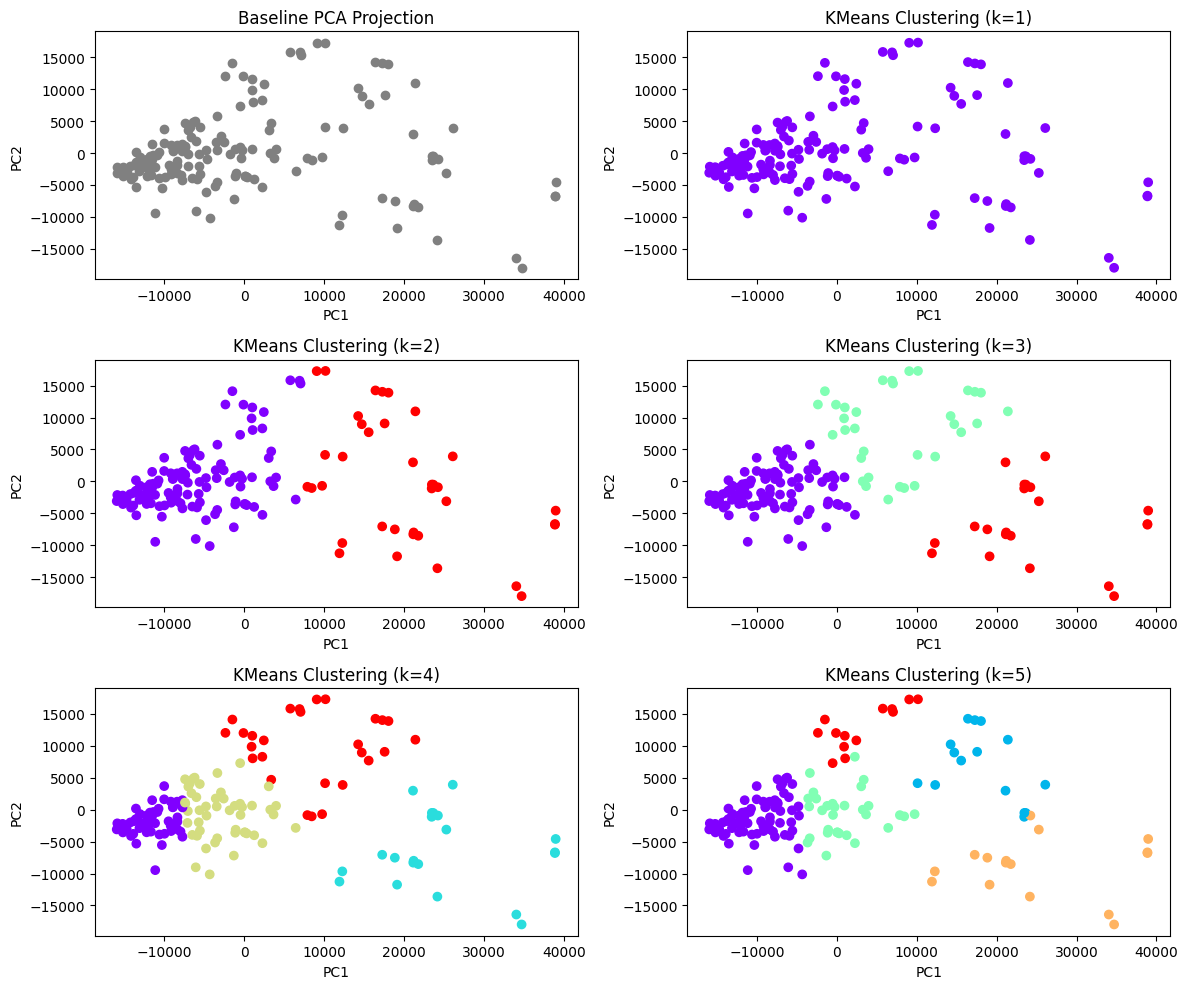

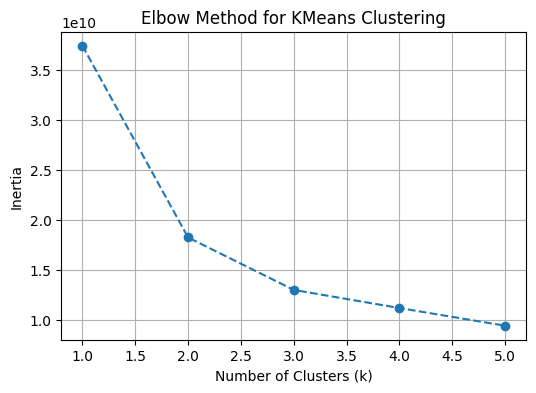

In [15]:
cluster_range = range(1, 6)
inertias = []  # list to store inertia values for each k

plt.figure(figsize=(12, 10))
plot_index = 1
total_plots = len(cluster_range) + 1  # +1 for the baseline PCA scatter

# Plot baseline PCA projection (all points in gray)
num_columns = 2
num_rows = (total_plots + num_columns - 1) // num_columns
plt.subplot(num_rows, num_columns, plot_index)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='gray', cmap='rainbow')
plt.title('Baseline PCA Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plot_index += 1

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, n_init='auto')
    clusters_k = kmeans.fit_predict(reduced_data)
    inertias.append(kmeans.inertia_)
    
    plt.subplot(num_rows, num_columns, plot_index)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters_k, cmap='rainbow')
    plt.title(f'KMeans Clustering (k={k})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plot_index += 1

plt.tight_layout()
plt.show()

# Plot the inertia (elbow method) vs. the number of clusters to help decide the ideal k.
plt.figure(figsize=(6, 4))
plt.plot(list(cluster_range), inertias, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for KMeans Clustering')
plt.grid(True)
plt.show()


Cluster 0 has 96 samples.


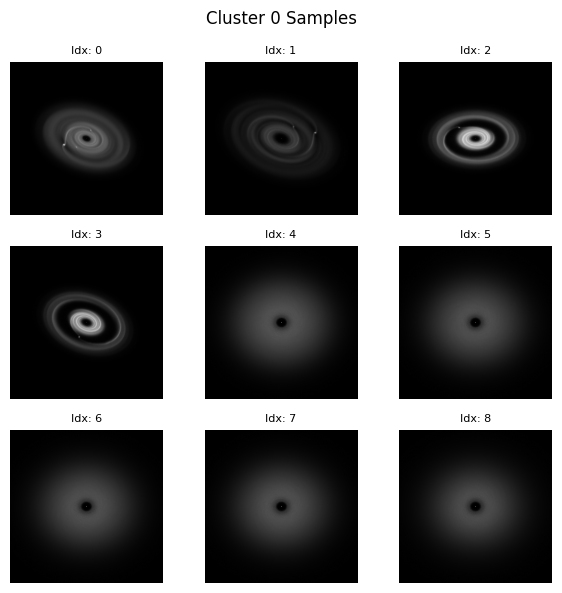

Cluster 1 has 21 samples.


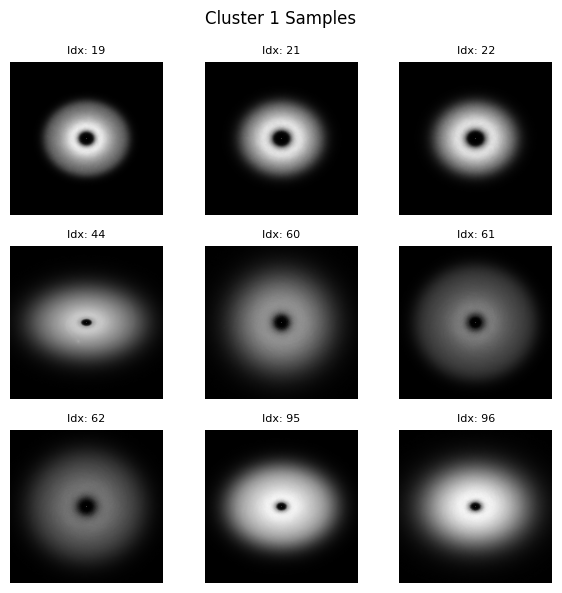

Cluster 2 has 33 samples.


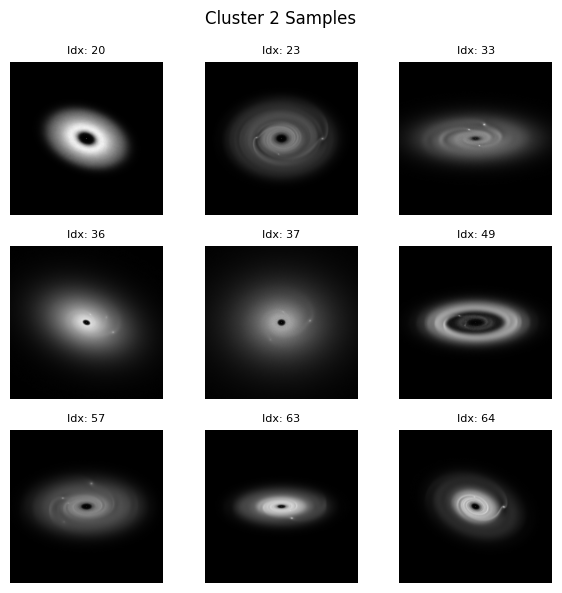

In [20]:
kmeans = KMeans(n_clusters=3, n_init='auto')
clusters_k = kmeans.fit_predict(reduced_data)

plot_cluster_samples(dataset, clusters_k, num_samples=9)

In the second experiment aimed at counting the number of exoplanets per image, the clustering with k=3 appears to separate the data into three distinct groups. The clusters display characteristic patterns; although the samples on the right of the PCA plot appear quite distant, the overall grouping seems coherent. The elbow method indicates an optimal k of 3, suggesting three potential labels.

This may imply that one cluster represents images without exoplanets, another contains images with a single exoplanet, and the last comprises images with two exoplanets. These initial findings offer promising insights into the underlying structure of the dataset, though further analysis is required to validate these interpretations.